# Regresión Logística

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
import time

## Carga de datos

In [ ]:
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')
test = pd.read_csv('data/test.csv')

In [ ]:
X_train = np.array(train.copy().drop(columns=['fetal_health']))
y_train = np.array(train['fetal_health'])

X_val = np.array(val.copy().drop(columns=['fetal_health']))
y_val = np.array(val['fetal_health'])

X_test = np.array(test.copy().drop(columns=['fetal_health']))
y_test = np.array(test['fetal_health'])

Con regresión logitica solo podemos resolver problemas de clasificación `binaria`, pero en nuestro 
dataset contamos con `tres clases`: normal, sospechoso y patológico. `Necesitamos adaptar` el problema
y los datos para que se ajusten a las limitaciones del clasificador.
Vamos centrarnos en la distinción entre normal y sospechoso/patológico.

In [ ]:
# cambiamo las etiquetas, 1 es "normal", pasa a ser 0
# 2 y 3, "sospechoso" y "patológico" respectivamente, pasan a ser 1
y_train = np.where(y_train == 1, 0, 1)
y_val = np.where(y_val == 1, 0, 1)
y_test = np.where(y_test == 1, 0, 1)

Como tenemos dos clases `desequilbradas`, usaremos la metrica `F1` en vez de la accuracy para evaluar los distintos clasificadores

In [ ]:
np.sum(y_train == 0), np.sum(y_train == 1)

(992, 283)

La regresión logistica es un modelo muy sencillo que tiene poca capacidad de memorización si la cantidad de datos es muy superior al número de variables (o lo que es lo mismo, parámetros) En nuestro caso el ratio n_datos / variables > 50. No memoriza datos de entrenamiendo -> no se produce overfitting -> la regularización tiene poco efecto.


Para poder apreciar los efectos de la regularización y mejorar la calidad del modelo, vamos a `añadir nuevas variables` como combinación de las actuales.

In [ ]:
poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.fit_transform(X_val)
X_test_poly = poly.fit_transform(X_test)
print("Num of varibles: ", X_train_poly.shape[1])

Num of varibles:  2600


En nuestro primer intento lo hicimos sin aumentar el número de variables, y efectivamente, el factor de regularización afectaba poco a la calidad del modelo y los resultados eran notablemente inferiores a los obtenidos usando esta técnica.

## Ajuste del modelo

### Definición de funciones auxiliares
Código de prácticas anteriores. Se han combinado las funciones de calculo de gradiente y del coste para aumentar la eficiencia, pues tenían cálculos en común.

In [ ]:
# Definimos la función sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
# Calculamos el coste y los gradientes
def grad_cost(w, b, X, Y, lmbda):
    m = X.shape[0]
    z = np.dot(X, w) + b
    A = sigmoid(z)

    # calculamos el coste con su formula
    cost = -np.sum(Y*np.log(A)+(1-Y)*np.log(1-A + 1e-10))/m + lmbda/(2*m)*np.sum(w**2)

    # calculamos los gradientes de los parametros
    wgrad = 1/m * np.dot((A - Y), X) + lmbda/m * w
    bgrad = 1/m * np.sum(A - Y)
    
    return wgrad, bgrad, cost

In [ ]:
# Definimos la función de descenso de gradiente
def gradient_descent(X, Y, alpha=0.01, lmbda=0.01, max_iter=1000):
    n_features = X.shape[1] # Numero de variables

    # inicializamos los pesos y el bias a valores aleatorios
    w = np.random.randn(n_features) * 0.1 
    b = np.random.randn() * 0.1

    costs = [] # Lista para almacenar los costes

    # Actualizamos los pesos y el bias con cada iteración
    for i in range(max_iter):
        # Calculamos el coste y los gradientes
        grad_w, grad_b, cost = grad_cost(w, b, X, Y, lmbda)

        # Actualizamos los pesos y el bias
        w = w - alpha*grad_w
        b = b - alpha*grad_b

        costs.append(cost)

    return w, b, costs # Devolvemos los parámetros entrenados y la lista de costes por iteración

In [ ]:
# Definimos la función de predicción
def predict(w, b, X):
    z = np.dot(X, w) + b
    A = sigmoid(z)
    return np.where(A >= 0.5, 1, 0)

### Entrenamiento

Iteramos sobre las distintas combinaciones de hiperparámetros (learning rate y regularización) y calculamos el F1 score en el set de validación para cada una de ellas.

In [ ]:
alphas = [1e-1, 3e-2, 1e-2, 1e-3] # learning rate
lambdas = [300, 100, 30, 10, 1, 0.1, 1e-2, 0] # lambdas que queremos probar

f1_val = np.zeros((len(alphas),len(lambdas))) # resultados para cada [alpha, lambda]
f1_train = np.zeros((len(alphas),len(lambdas))) # resultados para cada [alpha, lambda]
losses = [] # loss por iteración para cada [alpha, lambda]

for i, alpha in enumerate(alphas):
  losses_alpha = []
  for j, lmbda in enumerate (lambdas):
      # entrenamos el modelo con los hiperparámetros correspondientes
      w, b, costs = gradient_descent(X_train_poly, y_train, alpha, lmbda, max_iter=10000)

      # guardamos el loss por iteración 
      losses_alpha.append(costs)

      # F1 score obtenido en el conjunto de validación
      y_pred = predict(w, b, X_val_poly)
      f1 = f1_score(y_val, y_pred, average='weighted')
      f1_val[i, j] = f1

      # F1 score obtenido en el conjunto de train
      y_pred = predict(w, b, X_train_poly)
      f1 = f1_score(y_train, y_pred, average='weighted')
      f1_train[i, j] = f1

  losses.append(losses_alpha)

### Selección de hiperparámetros
Seleccionamos la mejor combinación de hiperparámetros -> los que maximizan el F1 score en el conjunto de validación

In [ ]:
best_alpha_indx = np.argmax(np.max(f1_val, axis=1))
best_lambda_indx = np.argmax(f1_val[best_alpha_indx])
best_alpha, best_lambda = alphas[best_alpha_indx], lambdas[best_lambda_indx]
print("Best alpha: ", best_alpha)
print("Best lambda: ", best_lambda)
print("Best F1 score: ", np.max(f1_val))

Best alpha:  0.03
Best lambda:  30
Best F1 score:  0.9459056241945529


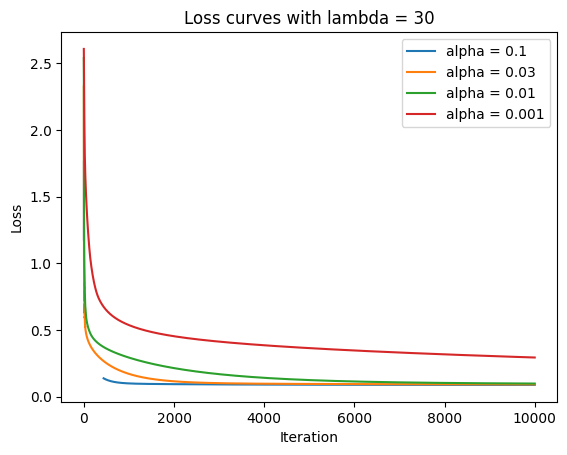

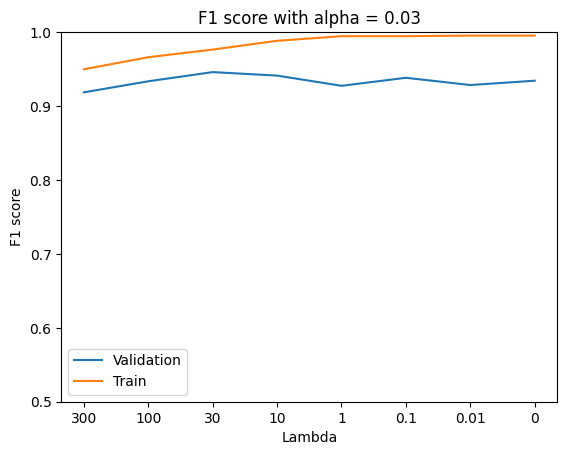

In [ ]:
# mostramos las loss curves para cada alpha con el mejor lambda
for i, alpha in enumerate(alphas):
    plt.plot(range(len(losses[i][best_lambda_indx])), losses[i][best_lambda_indx], label="alpha = " + str(alpha))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss curves with lambda = " + str(best_lambda))
plt.legend() 
plt.show()

# mostramos el efecto de la regularización para el mejor alpha
plt.plot(range(len(lambdas)), [f1_val[best_alpha_indx][i] for i in range(len(lambdas))], label="Validation")
plt.plot(range(len(lambdas)), [f1_train[best_alpha_indx][i] for i in range(len(lambdas))], label="Train")
plt.ylim(0.5, 1)
plt.title("F1 score with alpha = " + str(best_alpha))
plt.xticks(range(len(lambdas)), lambdas)
plt.xlabel("Lambda")
plt.ylabel("F1 score")
plt.legend()
plt.show()

Con la primera gráfica nos aseguramos de que el modelo está suficientemente entrenado y que no necesita más iteraciones, pues el loss no disminuye más.

En la segunda gráfica podemos apreciar que el factor de regularización nos ayuda a generalizar y obtener resultados ligeramente mejores. Con una lambda menor de 1, se ve que claramente el clasificador hace overfitting, pues el F1 score en el conjunto de entrenamiento es prácticamente 1 y mucho mayor que el de validación. Con una lambda mayor de 30 vemos que tanto el conjunto de entrenamiento como el de validación tienen un F1 score mas bajo, por lo que estamos aplicando demasida regularización. Con lambda = 30 obtenemos el mejor resultado para el conjunto de validación y conseguimos que no sea demasiado dispar con el obtenido para el conjunto de entrenamiento.

### Entrenamiento del modelo final
Por último, una vez seleccionados los mejores hiperparámetros, combinamos los datos del training set y del set de validación para entrenar al modelo.

In [ ]:
# concatenamos los conjuntos de entrenamiento y validación
X_train_val = np.concatenate((X_train_poly, X_val_poly), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

Medimos el tiempo de entrenamiento final

In [ ]:
time_start = time.time()
# entrenamos el modelo con los mejores hiperparámetros
w, b, costs = gradient_descent(X_train_val, y_train_val, best_alpha, best_lambda, max_iter=10000)
time_end = time.time()

print("Time: ", time_end - time_start)

Time:  16.031294107437134


## Análisis de Resultados

Analizamos los resultados obtenidos con el modelo final en el conjunto de test, que no se ha usado hasta ahora, para poder estimar su calidad con datos no vistos, es decir, ver cómo se comportaría en la realidad.

F1 score:  0.9244144700243098
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       331
           1       0.84      0.82      0.83        94

    accuracy                           0.92       425
   macro avg       0.89      0.89      0.89       425
weighted avg       0.92      0.92      0.92       425



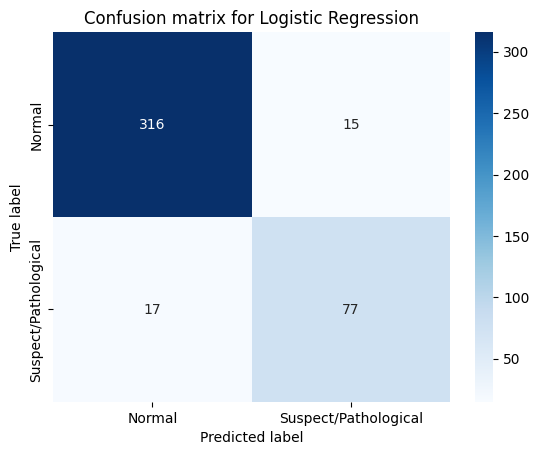

In [ ]:
# mostramos el classification report
y_pred = predict(w, b, X_test_poly)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score: ", f1)
print(classification_report(y_test, y_pred))

# mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Suspect/Pathological'], 
            yticklabels=['Normal', 'Suspect/Pathological'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for Logistic Regression')
plt.show()

Los resultados son relativamente buenos, obtenemos una precisión del 92% con un clasificador extremadamente sencillo, ligero y rápido de entrenar. No somos capaces de distinguir entre los casos sospechosos y patológicos, pero si que podemos distinguir entre los casos normales y los que no lo son con relativo exito. 

Lo más problemático de nuestro clasificador son los 17 casos sospechosos/patológicos que clasifica como normales. Esto es un problema, pues son los casos que más nos interesa detectar. Esto se ve reflejado en el recall de la clase 1, que es tan solo del 82%. Podemos ver si esos 17 que clasifica mal son casos sospechosos o patológicos, lo que nos puede dar una pista de por qué los clasifica mal. Si son una gran mayoría de sospechosos y hay pocos patológicos mal clasificados, este dato de recall no sería tan preocupante.

In [ ]:
# obtenemos los indices de los ejemplos mal clasificados como normales
missclassified = np.where(y_pred < y_test)[0]

# Vamos al dataset original y vemos de que tipo eran realmente
df_missclassified = test.iloc[missclassified]
df_missclassified['fetal_health'].value_counts()

2.0    16
3.0     1
Name: fetal_health, dtype: int64

Efectivamente, de los 17 diagnosticos peligrosamente incorrectos, solo 1 de ellos era realmente patológico y los 16 restantes meramente sospechosos. Sigue sin ser ideal, pero es un mejor resultado en la práctica.

# Extra: Decision Boundaries
A continuación hemos tratatado de dibujar las fronteras de decisión del modelo, con las variables emparejadas de 2 a 2.
Sin embargo, al haber tantas dimensiones, no parece que se pueda apreciar nada. También es posible que la función no sea del todo correcta.

In [ ]:
# encontrar los índices de los coeficientes de xi, xj, xi^2, xj^2, xi*xj, xi^3, xj^3, xi^2*xj, xj^2*xi
def find_index(fx, fy):
    l = []
    for i, e in enumerate(poly.get_feature_names_out()):
        if e == "1": l.append(i)
        if "x" + str(fx) == e: l.append(i)
        if "x" + str(fy) == e: l.append(i)
        if "x" + str(fx) + " x" + str(fy) == e: l.append(i)
        if "x" + str(fy) + " x" + str(fx) == e: l.append(i)
        for r in range(1,4):
            if "x" + str(fx) + "^" + str(r) == e: l.append(i)
            if "x" + str(fy) + "^" + str(r) == e: l.append(i)
            if "x" + str(fx) + "^" + str(r) + " x" + str(fy) == e: l.append(i)
            if "x" + str(fx) + " x" + str(fy) + "^" + str(r) == e: l.append(i)
            if "x" + str(fy) + "^" + str(r) + " x" + str(fx) == e: l.append(i)
            if "x" + str(fy) + " x" + str(fx) + "^" + str(r) == e: l.append(i)
    return l



def plot_decision_boundary(plt, w, b, X, fx, fy):
    # El ramaño de la figura
    fx_min, fx_max = X[:, fx].min() - 0.1, X[:, fx].max() + 0.1
    fy_min, fy_max = X[:, fy].min() - 0.1, X[:, fy].max() + 0.1
    
    # Cramos una malla de puntos que representan los valores de fx y fy
    fxx, fyy = np.meshgrid(np.linspace(fx_min, fx_max, 100), np.linspace(fy_min, fy_max, 100))

    # Aplicamos el polinomio de grado 3 a los valores de la malla
    poly3 = PolynomialFeatures(3)
    transformed_meshgrid = poly3.fit_transform(np.c_[fxx.ravel(), fyy.ravel()])

    # Obtenemos los índices de los pesos que corresponden a las características de fx y fy
    index = find_index(fx, fy)
    
    # Obtenemos los pesos que corresponden a las características de fx y fy
    poly_weights = w[index]

    # Calculamos el valor de la función de decisión para los valores de la malla
    h = sigmoid(np.dot(transformed_meshgrid, poly_weights) + b)
    
    # volvemos al tamaño original
    h = h.reshape(fxx.shape)

    # Dibujamos las curvas
    plt.contour(fxx, fyy, h, levels=[0.5], colors=['green'])

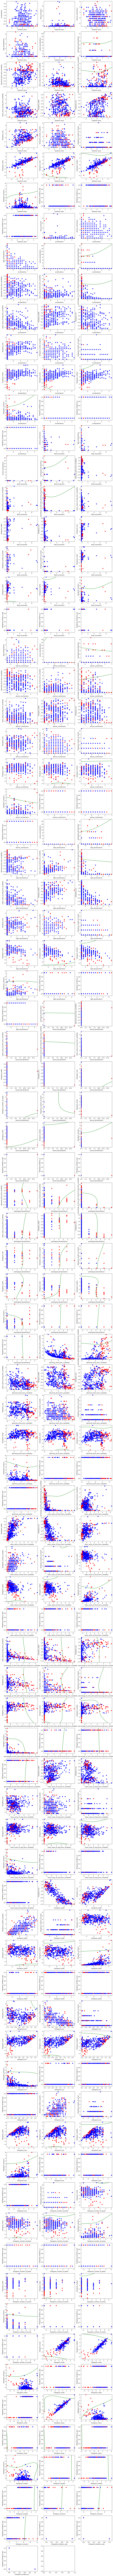

In [ ]:
features = [i for i in range(23)]
plt.figure(figsize=(15, 400))
count = 1
for i, fx in enumerate(features):
    for j, fy in enumerate(features[i+1:]):
        plt.subplot(92, 3, count)
        count += 1
        plt.scatter(X_test[:, fx], X_test[:, fy], c=y_test, cmap=plt.cm.bwr)
        plot_decision_boundary(plt, w, b, X_test, fx, fy)
        plt.xlabel(test.columns[fx])
        plt.ylabel(test.columns[fy])
        plt.subplot(92, 3, count)
plt.show()
